# Fitting

This notebook is intended to fit the data associated with human CRISPRi activity scores to train a linear regression model to.

The data used is that from the following paper:

[Compact and highly active next-generation libraries for CRISPR-mediated gene repression and activation](https://elifesciences.org/articles/19760)

__Authors__: Anthony Hein, Briana Macedo

---

We will attempt to build the following models:
* Fully Connected Neural Network
* Support Vector Machine
* Logisitc Regression
* Elastic Net Linear Regression

_NOTE_ : The paper only creates an Elastic Net Linear Regression model.

---

## Imports and Configuration

In [120]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import cm

from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.datasets import make_regression
from sklearn.model_selection import KFold
from sklearn.linear_model import ElasticNetCV, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import roc_auc_score

In [121]:
np.random.seed(0)

---

## Dataframe to Array

In [122]:
features_raw = pd.read_csv('features_binned.csv')
features_raw.head()

,Unnamed: 0,+ve strand,pos_-27_A,pos_-27_C,pos_-27_G,pos_-27_T,pos_-26_A,pos_-26_C,pos_-26_G,pos_-26_T,...,AG_comp_0.9,AG_comp_1.0,length_18,length_19,length_20,length_21,length_22,length_23,length_24,length_25
0,0,1,0,0,0,0,0,0,0,0,...,False,False,False,False,False,True,False,False,False,False
1,1,1,0,0,0,0,0,0,0,0,...,False,False,False,False,False,True,False,False,False,False
2,2,1,0,0,0,0,0,0,0,0,...,False,False,False,False,False,True,False,False,False,False
3,3,1,0,0,0,0,0,0,0,0,...,False,False,False,False,False,True,False,False,False,False
4,4,1,0,0,0,0,0,0,0,0,...,False,False,False,False,False,True,False,False,False,False


In [123]:
scores_arr = np.array(pd.read_csv('features.csv')['score'])
scores_arr

array([0.01932036, 0.34889211, 0.91240883, ..., 0.215028  , 1.17072619,
       0.57770586])

In [124]:
features_df = features_raw.drop(columns=['Unnamed: 0'])
features_arr = np.array(features_df)
features_arr

array([[1, 0, 0, ..., False, False, False],
       [1, 0, 0, ..., False, False, False],
       [1, 0, 0, ..., False, False, False],
       ...,
       [0, 0, 0, ..., False, False, False],
       [0, 0, 0, ..., False, False, False],
       [0, 0, 0, ..., False, False, False]], dtype=object)

---

## Standardize Data to N(0, 1)

In [125]:
scaler = StandardScaler()
scaler.fit(features_arr)
features_arr_std = scaler.transform(features_arr)

In [126]:
### CHECK ###
idxs = np.random.choice(features_arr_std.shape[1], size=5)
for idx in idxs:
    assert abs(np.mean(features_arr_std[:, idx])) < 1e-2
    assert abs(np.std(features_arr_std[:, idx]) - 1) < 1e-2

---

## Create K=5 Folds

In [158]:
Xs_train = []
Ys_train = []

Xs_test = []
Ys_test = []

splits = []

folds = KFold(n_splits=5, shuffle = True)

for train_index, test_index in folds.split(features_arr_std):

    Xs_train.append(features_arr_std[train_index])
    Ys_train.append(scores_arr[train_index])
    
    Xs_test.append(features_arr_std[test_index])
    Ys_test.append(scores_arr[test_index])
    
    splits.append( (train_index, test_index) )

---

# Models

### Elastic Net

In [183]:
models = []
coefs = []

In [184]:
# train K=5 models
for i in range(len(splits)):
    model = ElasticNetCV(cv=splits[i:i+1], random_state=0, max_iter=100000)
    model.fit(features_arr_std, scores_arr)
    coefs.append(model.coef_)
    models.append(model)

In [185]:
# performance metrics
rs_squared = []
rs = []
accuracies = []

for model in models:
    
    r_squared = model.score(features_arr_std, scores_arr)
    r = np.sqrt(r_squared)

    preds_arr = model.predict(features_arr_std)
    preds_bin = preds_arr > 0.75
    scores_bin = scores_arr > 0.75
    incorrect = np.logical_xor(preds_bin, scores_bin)
    accuracy = np.mean(np.logical_not(incorrect))
    
    rs_squared.append(r_squared)
    rs.append(r)
    accuracies.append(accuracy)

In [186]:
# save performance to csv
data = {
    'R Squared':rs_squared,
    'R': rs,
    'Accuracy': accuracies
} 
   
df = pd.DataFrame(data) 
df.to_csv("elastic_net_performance.csv")

In [200]:
# find coefficients

mean_arr = np.mean(np.array(coefs), axis=0)
min_arr = np.min(np.array(coefs), axis=0)
max_arr = np.max(np.array(coefs), axis=0)

tpl_arr = np.stack([mean_arr, min_arr, max_arr])

In [201]:
# save coefficients to numpy object
np.save("coef_elastic.npy", tpl_arr)

### TODO: Other Models

---

## TODO: Figure 1B

In [100]:
fpr, tpr, thresholds = metrics.roc_curve(scores_bin, preds)

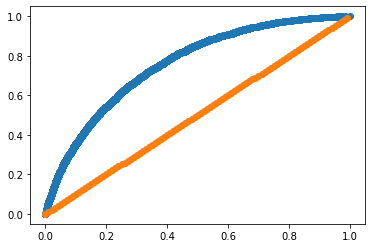

In [101]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(fpr, tpr)
ax1.scatter(np.arange(0,1,0.01), np.arange(0,1,0.01))
plt.show()

In [102]:
roc_auc_score(scores_bin, preds)

0.7583024032598393

---

## TODO: Figure 1C

In [108]:
mostNeg5 = np.argsort(regr.coef_)[0:5]
mostNeg5

array([462, 478, 468,  83, 379])

In [109]:
features_df.columns[mostNeg5]

Index(['pos_-5_GC', 'pos_-4_GC', 'pos_-5_TT', 'pos_-7_G', 'pos_-10_CG'], dtype='object')

In [110]:
mostPos5 = np.argsort(regr.coef_)[-5:]
mostPos5

array([ 93, 594, 595, 485, 486])

In [111]:
features_df.columns[mostPos5]

Index(['pos_-4_A', 'length_19', 'length_20', 'dist prim 3'', 'dist prim 5''], dtype='object')

---

## TODO: Figure 1D

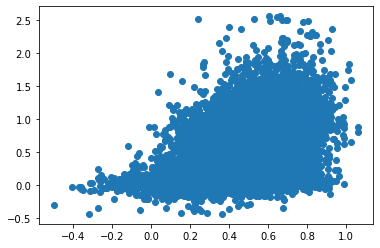

In [107]:
plt.scatter(preds, scores_arr)